## results of splitting dataset so target only ever appears on one side in training set but appears on both sides in test set

In [76]:
import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import searchnets
from searchnets import plot
from searchnets.utils.metrics import compute_d_prime

In [56]:
HERE = Path('/home/bart/Documents/repos/L2M/visual-search-nets/docs/notebooks/supp-info')

In [57]:
results_dir = HERE.joinpath('../../../data/expt_13/results/')
data_prep_dir = HERE.joinpath('../../../data/expt_13/data_prepd_for_nets/')
vis_search_stims_dir = HERE.joinpath('../../../data/visual_search_stimuli/')

In [58]:
test_csv_path = '../../../data/expt_13/csv/alexnet_train_test_target_split_data.csv'

In [59]:
GRID_SHAPE = (5, 5)
TRAIN_MASK = np.zeros(GRID_SHAPE).astype(np.int32)
TRAIN_MASK[:, :3] = 1

In [77]:
HEADER = ['net_name',
          'train_type',
          'net_number',
          'stimulus',
          'set_size',
          'target_condition',
          'accuracy',
          'hit_rate',
          'false_alarm_rate',
          'd_prime',
          ]

def split_results_df(results_dir,
                     data_prepd_dir,
                     vis_search_stims_dir,
                     test_csv_path=test_csv_path,
                     train_mask=TRAIN_MASK,
                     nets=('alexnet',),
                     train_types=('train_test_target_split', 'train_less_shards'),
                     stims=('2_v_5', 'RVvGV', 'RVvRHGV'),
                     target_condition=('present_all', 'present_train_only', 'present_test_only' 'absent', 'both')):
    """create dataframe from results where dataset was split so target appears in locations in test set that never appeared in training set"""
    rows = []
    for train_type in train_types:
        for net in nets:
            for stim in stims:
                data_gz_path = data_prepd_dir.joinpath(f'{net}_{train_type}_{stim}_data.gz')
                data_dict = joblib.load(data_gz_path)
                x_test = data_dict['x_test']
                y_test = data_dict['y_test']
                set_size_vec_test = data_dict['set_size_vec_test']
                set_sizes = data_dict['set_sizes_by_stim_type'][stim]

                json_fname = vis_search_stims_dir.joinpath(f'{net}_train_{stim}/{net}_train_{stim}.json')
                if json_fname.exists():
                        with open(json_fname) as fp:
                            stim_meta_dict = json.load(fp)

                        stim_meta_list = []
                        stim_meta_dict = stim_meta_dict[stim]
                        for set_size, stim_meta_this_set_size in stim_meta_dict.items():
                            # *** only using present because we only care about splitting target present condition up ***
                            stim_meta_list.extend(stim_meta_this_set_size['present'])

                        fname_grid_map = {}
                        for meta_d in stim_meta_list:
                            stim_fname_meta = Path(meta_d['filename']).name
                            char_grid = np.asarray(meta_d['grid_as_char'])
                            fname_grid_map[stim_fname_meta] = char_grid

                # figure out from character grid if target appears within area of mask used to make training data set
                # i.e. if the trained network has seen the target in this location before
                target_in_mask = []
                for fname in x_test:
                    fname = Path(fname).name
                    if 'absent' in fname:
                        # -1 means "not a target present stimulus"
                        target_in_mask.append(-1)
                    elif 'present' in fname:
                        char_grid = fname_grid_map[fname]
                        if np.any(np.logical_and(char_grid == 't', train_mask)):
                            # 1 means, yes, target appears within mask, 
                            # i.e., target appeared here in training set -- network has seen this location
                            target_in_mask.append(1)
                        else:
                            # 0 means, no, target did not appear here in training set -- network has not seen this location
                            target_in_mask.append(0)

                target_in_mask = np.asarray(target_in_mask)

                results_gz_path = list(results_dir.joinpath(f'{net}_{train_type}_{stim}').glob(f'*test*.gz'))
                if len(results_gz_path) == 1:
                    results_gz_path = results_gz_path[0]
                else:
                    raise ValueError(
                        f'did not find only a single results_gz_path, instead found: {results_gz_path}'
                    )
                
                results_dict = joblib.load(results_gz_path)
                ppm = results_dict['predictions_per_model_dict']
                num_nets = len(ppm.keys())
                for net_num in range(num_nets):
                    key = [key for key in ppm.keys() if f'net_number_{net_num}' in key][0]
                    y_pred = ppm[key]
                    for target_cond in target_condition:
                        for set_size in set_sizes:
                            if target_cond == 'present_all':
                                inds_this_cond = np.where(
                                    np.logical_and(y_test == 1, set_size_vec_test == set_size))
                            elif target_cond == 'present_train_only':
                                inds_this_cond = np.where(
                                    np.logical_and(target_in_mask == 1, set_size_vec_test == set_size))
                            elif target_cond == 'present_test_only':
                                inds_this_cond = np.where(
                                    np.logical_and(target_in_mask == 0, set_size_vec_test == set_size))                                
                            elif target_cond == 'absent':
                                inds_this_cond = np.where(
                                    np.logical_and(y_test == 0, set_size_vec_test == set_size))
                            elif target_cond == 'both':
                                inds_this_cond = np.where(set_size_vec_test == set_size)[0]
                            acc = np.sum(y_pred[inds_this_cond] == y_test[inds_this_cond])
                            acc = acc / y_test[inds_this_cond].shape[0]

                            if target_cond == 'both':
                                hit_rate, false_alarm_rate, d_prime = compute_d_prime(
                                    y_pred[inds_this_cond], y_test[inds_this_cond]
                                )
                            else:
                                hit_rate, false_alarm_rate, d_prime = None, None, None
                            row = [net, train_type, net_num, stim, set_size, target_cond,
                                   acc, hit_rate, false_alarm_rate, d_prime]
                            rows.append(row)

    df = pd.DataFrame.from_records(rows, columns=HEADER)
    return df

In [81]:
df = split_results_df(results_dir,
                      data_prep_dir,
                      vis_search_stims_dir,
                      test_csv_path=test_csv_path,
                      nets=('alexnet',),
                      train_types=('train_test_target_split', 'train_less_shards'),
                      stims=('2_v_5', 'RVvGV', 'RVvRHGV'),
                      target_condition=('present_all', 'present_train_only', 'present_test_only', 'absent', 'both'))

In [86]:
df[(df['train_type']=='train_less_shards') & (df['stimulus'] == '2_v_5')]

,net_name,train_type,net_number,stimulus,set_size,target_condition,accuracy,hit_rate,false_alarm_rate,d_prime
240,alexnet,train_less_shards,0,2_v_5,1,present_all,1.0,NaN,NaN,NaN
241,alexnet,train_less_shards,0,2_v_5,2,present_all,1.0,NaN,NaN,NaN
242,alexnet,train_less_shards,0,2_v_5,4,present_all,1.0,NaN,NaN,NaN
243,alexnet,train_less_shards,0,2_v_5,8,present_all,1.0,NaN,NaN,NaN
244,alexnet,train_less_shards,0,2_v_5,1,present_train_only,1.0,NaN,NaN,NaN
245,alexnet,train_less_shards,0,2_v_5,2,present_train_only,1.0,NaN,NaN,NaN
246,alexnet,train_less_shards,0,2_v_5,4,present_train_only,1.0,NaN,NaN,NaN
247,alexnet,train_less_shards,0,2_v_5,8,present_train_only,1.0,NaN,NaN,NaN
248,alexnet,train_less_shards,0,2_v_5,1,present_test_only,1.0,NaN,NaN,NaN
249,alexnet,train_less_shards,0,2_v_5,2,present_test_only,1.0,NaN,NaN,NaN


In [37]:
def one_net_three_stims(df, net_name, train_type, conditions=['present', 'absent'], figsize=(15, 5), ylim=(0.0, 1.05), add_legend=False, save_as=None):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=figsize)
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['feature', 'conjunction', 'spatial configuration'],
        ['RVvGV', 'RVvRHGV', '2_v_5'])):
        if add_legend:
            if col == 0:
                add_legend_this_plot=True
            else:
                add_legend_this_plot=False
        else:
            add_legend_this_plot=False
        plot.metric_v_set_size.metric_v_set_size_df(df, net_name, train_type=train_type, stimulus=stim_abbrev, metric='accuracy', conditions=conditions,
                                                    ylim=ylim, ax=ax[col], add_legend=add_legend_this_plot)

    if save_as:
        plt.savefig(save_as)

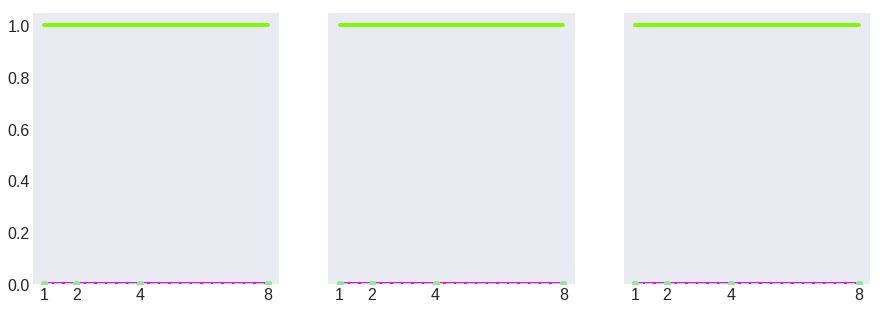

In [38]:
one_net_three_stims(df, 'alexnet', 'train_test_target_split')

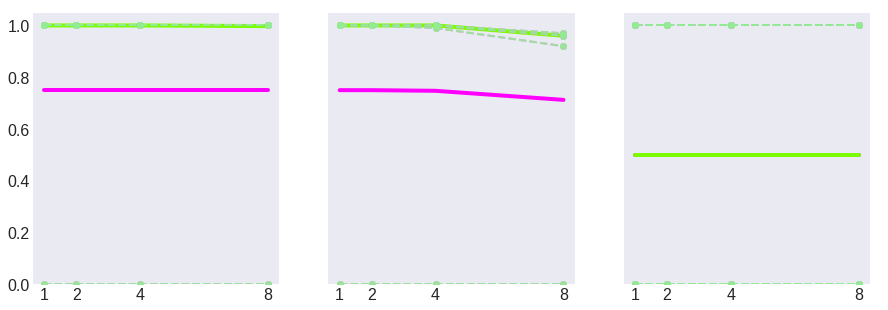

In [39]:
one_net_three_stims(df, 'alexnet', 'train_less_shards')

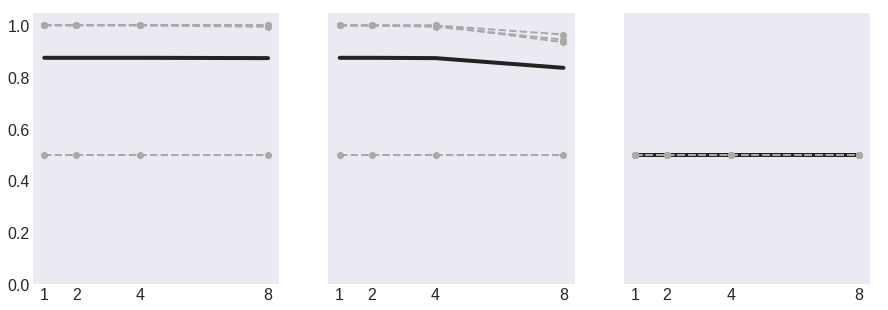

In [40]:
one_net_three_stims(df, 'alexnet', 'train_less_shards', conditions=['both'])

In [ ]:
def stat_diff(df, train_type, stimulus, target_condition, stat='accuracy'):
    df_to_use = df[
        (df['train_type'] == train_type) &
        (df['stimulus'] == stimulus) &
        (df['target_condition'] == target_condition)
    ]
    num_nets = df_to_use['net_number'].unique()
    set_sizes = df_to_use['set_size'].unique()
    min_set_size = set_sizes[0]
    max_set_size = set_sizes[-1]
    diffs = []
    for net_num in num_nets:
        min_stat = df_to_use[
            (df_to_use['net_number'] == net_num) &
            (df_to_use['set_size'] == min_set_size)][stat].values
        max_stat = df_to_use[
            (df_to_use['net_number'] == net_num) &
            (df_to_use['set_size'] == max_set_size)][stat].values
        diff = min_stat - max_stat
        diffs.append(diff)
    return diffs

In [ ]:
d = stat_diff(atft_df, 'finetune', '2_v_5', 'both')

In [ ]:
d

In [ ]:
d = stat_diff(atft_df, 'finetune', 'RVvGV', 'both')

In [ ]:
d
